In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import pydotplus
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score

import scikitplot as skplt 

In [2]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [3]:
df = pd.read_csv('trainingDataAfterDataUnderstanding.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
Occupancy        8143 non-null int64
Weekend          8143 non-null object
working_hours    8143 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 445.4+ KB


In [5]:
label_encoders = dict()
column2encode = ['Weekend', 'working_hours']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
attributes = [col for col in df.columns if col != 'Occupancy']

In [7]:
X = df.drop('Occupancy',axis=1)
y = df['Occupancy']

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [9]:
train_data = pd.concat([X_train, y_train], axis=1)

# Random Search

In [10]:
param_list = {
              'max_depth': [2, 3, 4, 5, 10, 20],
              'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100],
              'criterion': ['gini', 'entropy'],
             }

In [11]:
Rclf = DecisionTreeClassifier()

random_search = RandomizedSearchCV(Rclf, param_distributions=param_list, n_iter=100)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.990 (std: 0.002)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.990 (std: 0.002)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.989 (std: 0.002)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.989 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.989 (std: 0.002)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}



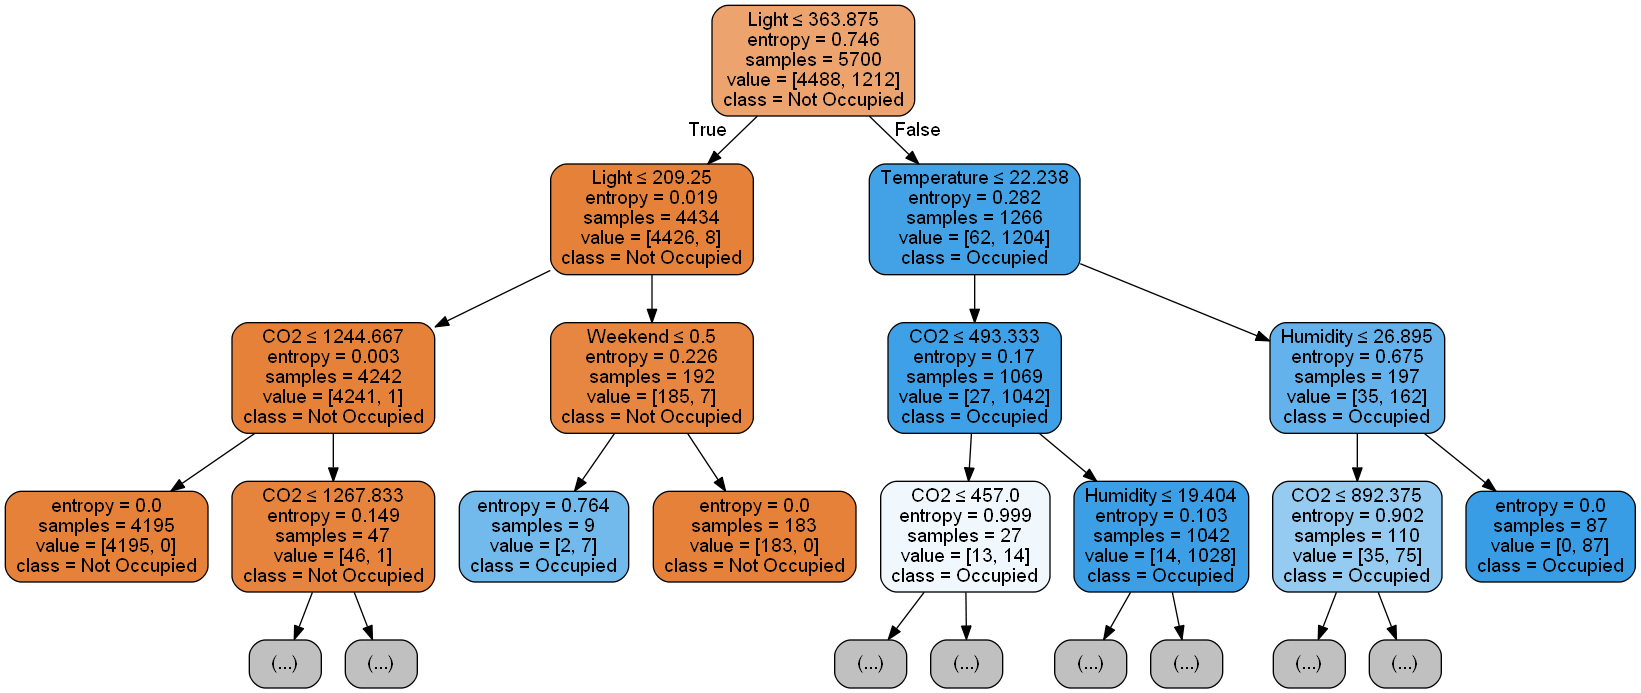

In [12]:
Rclfestimator=random_search.best_estimator_

dot_data = tree.export_graphviz(Rclfestimator, out_file=None,
                                feature_names=attributes,
                                class_names=['Occupied' if x == 1 else 'Not Occupied' for x in Rclfestimator.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [13]:
y_pred = Rclfestimator.predict(X_test)
y_pred_tr = Rclfestimator.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Train Accuracy 0.9947368421052631
Train F1-score [0.99665924 0.98760331]

Test Accuracy 0.9922226770364306
Test F1-score [0.99507644 0.98149951]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1926
           1       0.99      0.97      0.98       517

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



array([[1920,    6],
       [  13,  504]], dtype=int64)

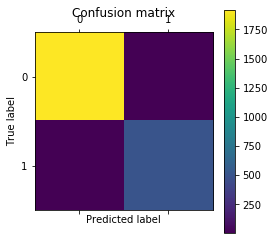

In [14]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.9858698337521166


0.9858698337521166

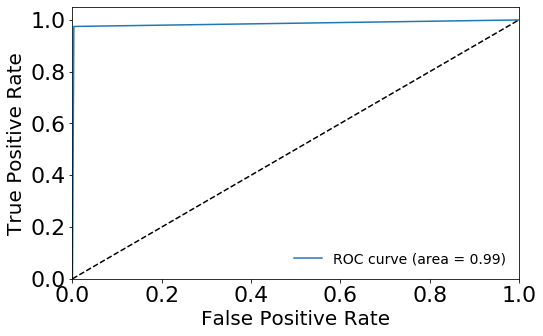

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

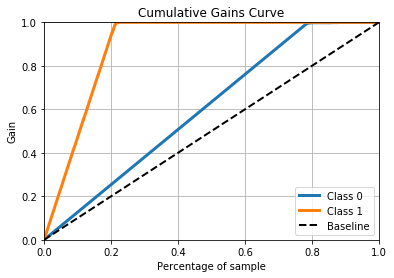

In [17]:
predicted_probas = Rclfestimator.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

# Grid Search

In [74]:
param_list = {
              'max_depth': list(np.arange(1, 2, 3)),
              'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 30, 50, 100],
              'min_samples_leaf': [1, 2, 3,  5, 10, 15, 20, 30, 50, 100],
              'criterion': ['gini', 'entropy'],
             }

In [75]:
Gclf = DecisionTreeClassifier()

grid_search = GridSearchCV(Gclf, param_grid=param_list)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.988 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.988 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.988 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: 0.988 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.988 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.988 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 15}

Model with rank: 1
Mean validation score: 0.

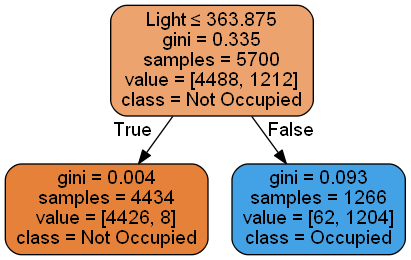

In [76]:
Gclfestimator=grid_search.best_estimator_

dot_data = tree.export_graphviz(Gclfestimator, out_file=None,
                                feature_names=attributes,
                                class_names=['Occupied' if x == 1 else 'Not Occupied' for x in Gclfestimator.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [77]:
y_pred = Gclfestimator.predict(X_test)
y_pred_tr = Gclfestimator.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Train Accuracy 0.987719298245614
Train F1-score [0.99215423 0.97175141]

Test Accuracy 0.9877200163733115
Test F1-score [0.99215481 0.97175141]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1926
           1       0.95      1.00      0.97       517

    accuracy                           0.99      2443
   macro avg       0.97      0.99      0.98      2443
weighted avg       0.99      0.99      0.99      2443



array([[1897,   29],
       [   1,  516]], dtype=int64)

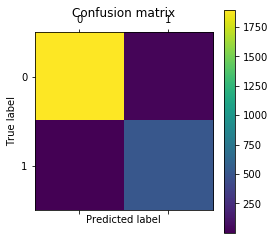

In [78]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [79]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.9915043254176282


0.9915043254176282

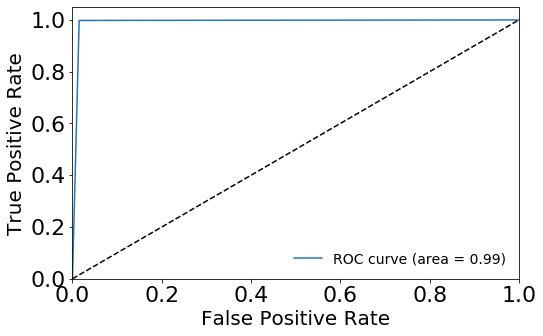

In [80]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

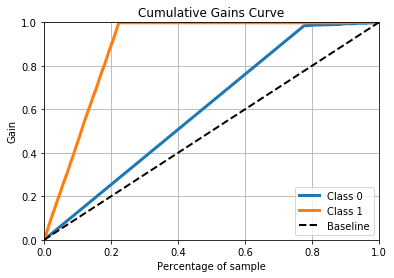

In [81]:
predicted_probas = Gclfestimator.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

In [82]:
predicted_probas

array([[0.99819576, 0.00180424],
       [0.99819576, 0.00180424],
       [0.99819576, 0.00180424],
       ...,
       [0.04897314, 0.95102686],
       [0.99819576, 0.00180424],
       [0.99819576, 0.00180424]])

# Test Grid Search

In [83]:
test = pd.read_csv('datatestprepared.csv')

In [84]:
class_name = 'Occupancy'
test_label_encoders = dict()
column2encode = ['Weekend', 'working_hours']

for col in column2encode:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])
    test_label_encoders[col] = le

In [85]:
test_feature = test.drop(['Occupancy'],axis=1)
test_label = test['Occupancy']

In [86]:
preds=Gclfestimator.predict(test_feature)

In [87]:
print('Test Accuracy %s' % accuracy_score(test_label, preds))
print('Test F1-score %s' % f1_score(test_label, preds, average=None))
print(classification_report(test_label, preds))
cm=confusion_matrix(test_label, preds)
cm

Test Accuracy 0.9900136909076266
Test F1-score [0.99336827 0.9797914 ]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9396
           1       0.97      1.00      0.98      3021

    accuracy                           0.99     12417
   macro avg       0.98      0.99      0.99     12417
weighted avg       0.99      0.99      0.99     12417



array([[9287,  109],
       [  15, 3006]], dtype=int64)

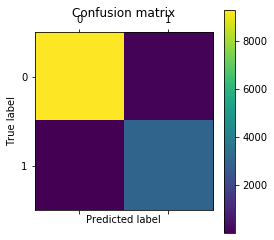

In [88]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [89]:
fpr, tpr, _ = roc_curve(test_label, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(test_label, preds, average=None)
roc_auc

0.9917170377810837


0.9917170377810837

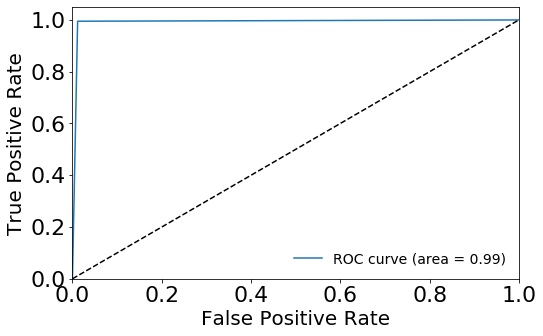

In [90]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

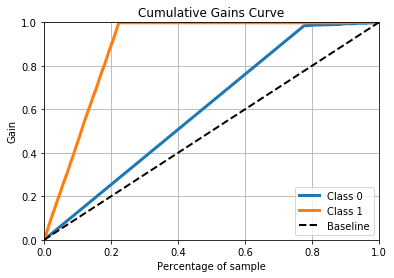

In [91]:
predicted_probas = Gclfestimator.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

# Cross Validation

In [92]:
from sklearn.model_selection import cross_val_score

In [93]:
CVclf = DecisionTreeClassifier()
scores = cross_val_score(CVclf, X, y, cv=4)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.953 +/- 0.016


In [94]:
CVclf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [95]:
preds=CVclf.predict(test_feature)

In [96]:
print('Test Accuracy %s' % accuracy_score(test_label, preds))
print('Test F1-score %s' % f1_score(test_label, preds, average=None))
print(classification_report(test_label, preds))
cm=confusion_matrix(test_label, preds)
cm

Test Accuracy 0.9340420391398888
Test F1-score [0.95689701 0.85959198]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9396
           1       0.89      0.83      0.86      3021

    accuracy                           0.93     12417
   macro avg       0.92      0.90      0.91     12417
weighted avg       0.93      0.93      0.93     12417



array([[9091,  305],
       [ 514, 2507]], dtype=int64)

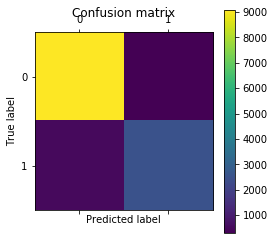

In [97]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

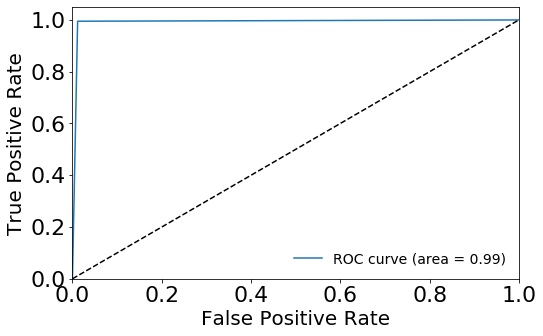

In [98]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

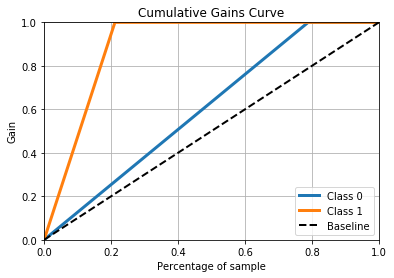

In [99]:
predicted_probas = CVclf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()